#Projeto 2 - Classificador multi-rótulo - arXiv Paper Abstract
##arXiv Paper Abstract - Kaggle
Este é um conjunto de artigos contidos no arXiv com múltiplo rótulos.

#Sobre este projeto
Os principais pontos que serão avaliados:
- Extração de dados
- Manipulação de dados e criação de gráficos simples com o Pandas
- Criar um modelo de predição
- Apresentação dos resultados

#Preparação do ambiente
Faça o download e carregue o dataset arXiv Paper Abstracts.

#Preparação do ambiente
Faça o download e carregue o dataset arXiv Paper Abstracts.
##Exercícios
- Questão 1) Faça a leitura dos dados e implemente rotinas de pré-processamento:
 - a) Implemente e justifique suas ações em relação ao tratamento dos rótulos (1,5 pontos)
  - b) Implemente e justifique suas ações em relação aos dados (titles e abstacts) (1,5 pontos)
- Questão 2) Faça uma análise visual do dataset após o pré-processamento. Explore gráficos e/ou tabelas para mostrar a distribuição dos rótulos. (1,0 ponto)
- Questão 3) Escolha uma metodologia para extração de características considerando somente o título dos artigos científicos. (1,0 ponto)
- Questão 4) Implemente o processo de classificação multi rótulos. Implemente 3 classificadores diferentes e compare suas performances. Escolha duas métricas distintas de sua escolha. Justifique suas escolhas e interprete os resultados (2,0 pontos)
- Questão 5) Replique os mesmos experimentos de extração de características e classificação considerando somente a coluna abstract. (2,0 pontos)
- Questão 6) Compare os resultados obtidos dos titles e abstracts. Qual atributo é mais discriminativo? (1,0 ponto)

In [ ]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.linear_model import RidgeClassifier, LogisticRegressionCV

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, auc, log_loss

##Questão 1) 
**Faça a leitura dos dados e implemente rotinas de pré-processamento** (3 pontos):

Usaremos a biblioteca NLTK, que é uma das principais bibliotecas de processamento de linguagem natural para estudo, pois contém muitos conjuntos de dados para análise e ferramentas de processamento de textos.

Criamos uma lista com as stopwords em inglês, usaremos o lemma e stemmer para normalizar as palavras. O objeto MultiLabelBinarizer será usado para separar os rótulos em colunas e, por fim, CountVectorizer, TfidfVectorizer e TfidfTransformer serão usados para extrair características das sinopses.

In [ ]:
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
mlb = MultiLabelBinarizer()
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
Tvectorizer = TfidfVectorizer()
tfidf_transformer = TfidfTransformer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Aqui faremos a leitura do dados

In [ ]:
arxiv_data = pd.read_csv('/content/arxiv_data.csv')

In [ ]:
# Versão alternativa
# arxiv_data = pd.read_csv(
#     "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
# )


Para Começar gostamos de entender o dados com os quais iremos trabalhar, neste caso serão artigos. O dados são compostos por 3 tipos de colunas, os títulos dos artigos, os resumos e por fim a classificação destes artigos, o assunto de que se trata, pode ser mais de um.

O objetivo deste projeto é, atravéz dos títulos e dos resumos, prever de quais assuntos este trata, iremos tratar os dados para que fiquem o mais padronizado possível, assim teremos uma boa predição.

Abaixo usaremos código para entender melhor sobre o dados.

In [ ]:
#tamanho do dataset
arxiv_data.shape

(51774, 3)

In [ ]:
#ver apresentação do dataset
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


**a) Implemente e justifique suas ações em relação ao tratamento dos rótulos** (1,5 pontos)

Agora vamos verificar a quantidade de vezes que cada rótulo se repete, assim podemos ver quais são os mais comuns, teoricamente os mais padronizados.

In [ ]:
arxiv_data.terms.value_counts()

['cs.CV']                                                            17369
['cs.LG', 'stat.ML']                                                  5251
['cs.LG']                                                             2732
['cs.CV', 'cs.LG']                                                    2067
['cs.LG', 'cs.AI']                                                    1702
                                                                     ...  
['cs.LG', 'stat.ML', 'I.6.4; I.5.3; I.4.6; I.2.4']                       1
['cs.LG', 'math.ST', 'stat.ML', 'stat.TH', '62H22, 62R01, 62J99']        1
['cs.LG', 'cs.RO', 'math.ST', 'stat.TH']                                 1
['cs.LG', 'cs.AI', 'cs.DS', '68T01, 68T09', 'I.2.6; I.5.1']              1
['stat.ML', 'cs.CV', 'cs.LG', 'q-bio.QM']                                1
Name: terms, Length: 3157, dtype: int64

Agora podemos fazer teste e verificar se é vantajoso manter todos os dados ou excluir os que tem poucas repetições.
Com certeza isso terá impacto no resultado final do nosso projeto, então é importante fazer testes e entender qual escolha nos levará à melhor precisão.

In [ ]:
contagem = arxiv_data.terms.value_counts()
manter = contagem[contagem > 50]
arxiv_data = arxiv_data[arxiv_data.terms.isin(manter.index)].reset_index(drop=True)

Foi feita a filtragem para que fiquem somente os que se repetem pelo menos 50 vezes.

**b) Implemente e justifique suas ações em relação aos dados (titles e abstacts)** (1,5 pontos)

Logo de começo vamos verficar se existem dados duplicados, pois estes não nos ajudam na predição e nos fazem gastar mais tempo e recursos.

In [ ]:
arxiv_data[arxiv_data["titles"].duplicated()]

,titles,summaries,terms
1253,Towards to Robust and Generalized Medical Imag...,"To mitigate the radiologist's workload, comput...","['cs.CV', 'cs.AI']"
1312,Box-Adapt: Domain-Adaptive Medical Image Segme...,Deep learning has achieved remarkable success ...,['cs.CV']
1322,PoissonSeg: Semi-Supervised Few-Shot Medical I...,The application of deep learning to medical im...,"['cs.CV', 'cs.LG']"
1358,SimCVD: Simple Contrastive Voxel-Wise Represen...,Automated segmentation in medical image analys...,"['cs.CV', 'cs.AI', 'cs.LG']"
1379,Contrastive Semi-Supervised Learning for 2D Me...,Contrastive Learning (CL) is a recent represen...,['cs.CV']
...,...,...,...
42763,Objective-Reinforced Generative Adversarial Ne...,"In unsupervised data generation tasks, besides...","['stat.ML', 'cs.LG']"
42764,Graph Memory Networks for Molecular Activity P...,Molecular activity prediction is critical in d...,['cs.LG']
42767,Stacked Denoising Autoencoders and Transfer Le...,In this paper we present a system for the dete...,['cs.CV']
42771,Graph Convolution: A High-Order and Adaptive A...,"In this paper, we presented a novel convolutio...","['cs.LG', 'stat.ML']"


Podemos verificar a existencia de 10816 artigos repetidos, vamos eliminá-los e manter apenas um de cada.

In [ ]:
arxiv_data["titles"][arxiv_data["titles"] == 'Partial Membership Latent Dirichlet Allocation']

953      Partial Membership Latent Dirichlet Allocation
16067    Partial Membership Latent Dirichlet Allocation
Name: titles, dtype: object

In [ ]:
dropar = arxiv_data["titles"].drop_duplicates(keep ='first')
arxiv_data = arxiv_data.iloc[dropar.index,:]

Agora vamos fazer variáveis para cada coluna, assim irá facilitar a manipulação dos dados

In [ ]:
titles = arxiv_data.titles
summaries = arxiv_data.summaries
terms  = arxiv_data.terms.apply(lambda x : [n.strip() for n in x.split(',')]).tolist()

O próximo passo, separaremos os rótulos em colunas preenchidos com 0 e 1

In [ ]:
mlb.fit(terms)
y = mlb.transform(terms)

In [ ]:
y[1]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
#downloads necessários para rodar o código abaixo
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

O próximo passo é processar as sinopses e o títulos, removendo as stopwords e normalizando o conteúdo.

In [ ]:
# funcao para tratar cada palavra e remover stopwords
def processamento(tokens):
    
    token_processado = []
    for token in tokens:
        token = token.lower()
        token = lemmatizer.lemmatize(token)
        
        if token not in stop_words:
            token = stemmer.stem(token)
            token_processado.append(token)
        
    return token_processado

documentos_summ = []
for summarie in summaries:
    
    # expressao regular para remover pontuacoes do texto
    summarie = re.sub(r'[^\w\s]','', summarie)
    tokens = processamento(word_tokenize(summarie))
    
    documentos_summ.append(' '.join(tokens))

documentos_title = []

for title in titles:
    
    # expressao regular para remover pontuacoes do texto
    sinopse = re.sub(r'[^\w\s]','', title)
    tokens = processamento(word_tokenize(title))
    
    documentos_title.append(' '.join(tokens))


##Questão 2) 
**Faça uma análise visual do dataset após o pré-processamento. Explore gráficos e/ou tabelas para mostrar a distribuição dos rótulos.** (1,0 ponto)

Text(0.5, 1.0, 'RÓTULOS(TERMS) MAIS COMUNS')

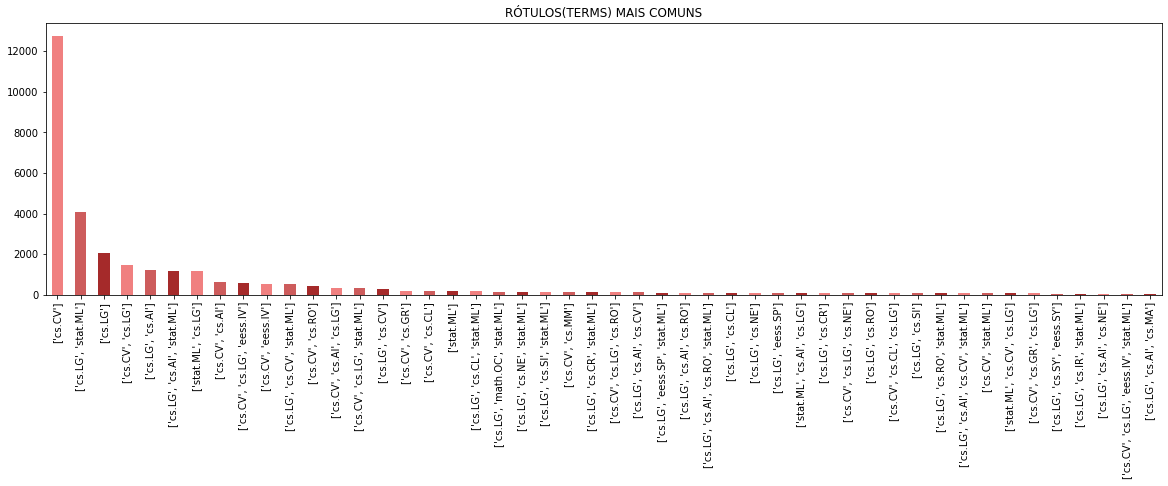

In [ ]:
plt.figure(figsize=(20,5))
arxiv_data.terms.value_counts()[arxiv_data.terms.value_counts()>50].plot.bar(color=["lightcoral","indianred","brown"])
plt.title('Rótulos(TERMS) mais comuns'.upper(), fontsize=12)

Aqui podemos ver quantas vezes cada rótulo se repete.

##Questão 3) 
**Escolha uma metodologia para extração de características considerando somente o título dos artigos científicos.** (1,0 ponto)

Utilizaremos o TF-IDF porque é melhor que o Count Vectorizers, ele não tem seu foco somente na frequencia das palavras como o Count, ele também leva em consideração a importancia das palavras. Podendo remover as palavras com menos importância, ficando o um dataset mais leve mais rádido de ser processado.

In [ ]:
#vecto = vectorizer
#X_train_counts = vectorizer.fit_transform(documentos_summ)
#Tvecto = Tvectorizer
X_train_Tvc = Tvectorizer.fit_transform(documentos_summ)
#X_new = SelectKBest(chi2, k=40000).fit_transform(X_train_counts, y)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_Tvc)


X_title = X_train_tfidf

##Questão 4)
**Implemente o processo de classificação multi rótulos. Implemente 3 classificadores diferentes e compare suas performances. Escolha duas métricas distintas de sua escolha. Justifique suas escolhas e interprete os resultados** (2,0 pontos)

Vamos utilizar 4 classificadores, SGDClassifier, BernoulliNB e RidgeClassifier. Para medirmos os resultados dos modelos acima usaremos 5 métricas, "f1_score","precision_score","recall_score","accuracy_score" e "log_loss". Cada uma delas tem suas próprias caracteristicas e revelam visões diferentes dos resultados, sempre é importante olhar mais que uma métrica para ter uma noção melhor dos resultados obtidos.

In [ ]:
metricas = pd.DataFrame({"Métricas_title": ["f1_score","precision_score","recall_score","accuracy_score","log_loss"]})

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(X_title, y,test_size=0.20, stratify = y, random_state=10)


svm = SGDClassifier() 
clf = OneVsRestClassifier(svm)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

m = "SGDClassifier1"
metricas[m] = [f1_score(y_test, y_pred, average="micro"),
                    precision_score(y_test, y_pred, average='micro'),
                     recall_score(y_test, y_pred, average='micro'),
                     accuracy_score(y_test, y_pred),
                      log_loss(y_test, y_pred)]
metricas

,Métricas_title,SGDClassifier1
0,f1_score,0.469238
1,precision_score,0.721201
2,recall_score,0.347747
3,accuracy_score,0.340266
4,log_loss,23.961590


In [ ]:
BNB = BernoulliNB() 
clf = OneVsRestClassifier(BNB)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

m = "BernoulliNB1"
metricas[m] = [f1_score(y_test, y_pred, average="micro"),
                    precision_score(y_test, y_pred, average='micro'),
                     recall_score(y_test, y_pred, average='micro'),
                     accuracy_score(y_test, y_pred),
                      log_loss(y_test, y_pred)]
metricas

,Métricas_title,SGDClassifier1,BernoulliNB1
0,f1_score,0.469238,0.516146
1,precision_score,0.721201,0.616457
2,recall_score,0.347747,0.443912
3,accuracy_score,0.340266,0.342924
4,log_loss,23.961590,23.514128


In [ ]:
Ridge = RidgeClassifier() 
clf = OneVsRestClassifier(Ridge)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

m = "Ridge1"
metricas[m] = [f1_score(y_test, y_pred, average="micro"),
                    precision_score(y_test, y_pred, average='micro'),
                     recall_score(y_test, y_pred, average='micro'),
                     accuracy_score(y_test, y_pred),
                      log_loss(y_test, y_pred)]
metricas

,Métricas_title,SGDClassifier1,BernoulliNB1,Ridge1
0,f1_score,0.469238,0.516146,0.470428
1,precision_score,0.721201,0.616457,0.678079
2,recall_score,0.347747,0.443912,0.360141
3,accuracy_score,0.340266,0.342924,0.334793
4,log_loss,23.961590,23.514128,23.208179


##Questão 5) 
**Replique os mesmos experimentos de extração de características e classificação considerando somente a coluna abstract.** (2,0 pontos)

In [ ]:
X_train_counts = vectorizer.fit_transform(documentos_summ)
X_train_Tvc = Tvectorizer.fit_transform(documentos_summ)
X_new = SelectKBest(chi2, k=40000).fit_transform(X_train_counts, y)
X_train_tfidf = tfidf_transformer.fit_transform(X_new)

X_summ = X_train_tfidf

In [ ]:
m = "Métricas_Summary"
metricas[m] = ["f1_score","precision_score","recall_score","accuracy_score","log_loss"]
metricas

,Métricas_title,SGDClassifier1,BernoulliNB1,Ridge1,Métricas_Summary
0,f1_score,0.469238,0.516146,0.470428,f1_score
1,precision_score,0.721201,0.616457,0.678079,precision_score
2,recall_score,0.347747,0.443912,0.360141,recall_score
3,accuracy_score,0.340266,0.342924,0.334793,accuracy_score
4,log_loss,23.961590,23.514128,23.208179,log_loss


In [ ]:
X_train, X_test,y_train, y_test = train_test_split(X_summ, y,test_size=0.20, stratify = y, random_state=10)


svm = SGDClassifier() 
clf = OneVsRestClassifier(svm)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

m = "SGDClassifier2"
metricas[m] = [f1_score(y_test, y_pred, average="micro"),
                    precision_score(y_test, y_pred, average='micro'),
                     recall_score(y_test, y_pred, average='micro'),
                     accuracy_score(y_test, y_pred),
                      log_loss(y_test, y_pred)]
metricas

,Métricas_title,SGDClassifier1,BernoulliNB1,Ridge1,Métricas_Summary,SGDClassifier2
0,f1_score,0.469238,0.516146,0.470428,f1_score,0.449579
1,precision_score,0.721201,0.616457,0.678079,precision_score,0.700901
2,recall_score,0.347747,0.443912,0.360141,recall_score,0.330921
3,accuracy_score,0.340266,0.342924,0.334793,accuracy_score,0.332134
4,log_loss,23.961590,23.514128,23.208179,log_loss,24.671401


In [ ]:
BNB = BernoulliNB() 
clf = OneVsRestClassifier(BNB)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

m = "BernoulliNB2"
metricas[m] = [f1_score(y_test, y_pred, average="micro"),
                    precision_score(y_test, y_pred, average='micro'),
                     recall_score(y_test, y_pred, average='micro'),
                     accuracy_score(y_test, y_pred),
                      log_loss(y_test, y_pred)]
metricas

,Métricas_title,SGDClassifier1,BernoulliNB1,Ridge1,Métricas_Summary,SGDClassifier2,BernoulliNB2
0,f1_score,0.469238,0.516146,0.470428,f1_score,0.449579,0.389722
1,precision_score,0.721201,0.616457,0.678079,precision_score,0.700901,0.448780
2,recall_score,0.347747,0.443912,0.360141,recall_score,0.330921,0.344400
3,accuracy_score,0.340266,0.342924,0.334793,accuracy_score,0.332134,0.388116
4,log_loss,23.961590,23.514128,23.208179,log_loss,24.671401,23.631922


In [ ]:
Ridge = RidgeClassifier()
clf = OneVsRestClassifier(Ridge)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

m = "Ridge2"
metricas[m] = [f1_score(y_test, y_pred, average="micro"),
                    precision_score(y_test, y_pred, average='micro'),
                     recall_score(y_test, y_pred, average='micro'),
                     accuracy_score(y_test, y_pred),
                      log_loss(y_test, y_pred)]
metricas

,Métricas_title,SGDClassifier1,BernoulliNB1,Ridge1,Métricas_Summary,SGDClassifier2,BernoulliNB2,Ridge2
0,f1_score,0.469238,0.516146,0.470428,f1_score,0.449579,0.389722,0.451527
1,precision_score,0.721201,0.616457,0.678079,precision_score,0.700901,0.448780,0.683670
2,recall_score,0.347747,0.443912,0.360141,recall_score,0.330921,0.344400,0.337073
3,accuracy_score,0.340266,0.342924,0.334793,accuracy_score,0.332134,0.388116,0.339797
4,log_loss,23.961590,23.514128,23.208179,log_loss,24.671401,23.631922,22.148222


##Questão 6)
**Compare os resultados obtidos dos titles e abstracts. Qual atributo é mais discriminativo?** (1,0 ponto)

In [ ]:
metricas

,Métricas_title,SGDClassifier1,BernoulliNB1,Ridge1,Métricas_Summary,SGDClassifier2,BernoulliNB2,Ridge2
0,f1_score,0.469238,0.516146,0.470428,f1_score,0.449579,0.389722,0.451527
1,precision_score,0.721201,0.616457,0.678079,precision_score,0.700901,0.448780,0.683670
2,recall_score,0.347747,0.443912,0.360141,recall_score,0.330921,0.344400,0.337073
3,accuracy_score,0.340266,0.342924,0.334793,accuracy_score,0.332134,0.388116,0.339797
4,log_loss,23.961590,23.514128,23.208179,log_loss,24.671401,23.631922,22.148222


Por incrivel que pareça, o atributo 'Summary', que é o resumo do artigo ficou pior classificado que o o tributo "title, titulo do artigo. Não há uma diferença muito grande, porem a predição atravez do título ficou melhor.

Neste projeto conseguimos fazer predições de artigos, os resultados não foram muito satisfatórios, porém é importante treinar e conhecer os métodos. Com toda certeza com mais tempo, experiência e se aprofundando mais no assunto conseguiriamos métricas melhores.